In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downlaod dataset from Kaggle: 

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d balraj98/horse2zebra-dataset

horse2zebra-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Extracting zip file : 

In [ ]:

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/kaggle/horse2zebra-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/horse2zebra_dataset')

Import library: 

In [ ]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random

#torch library:
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pylab as plt
import ipywidgets
from IPython import display

Running code on GPU or CPU: 

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The Code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Creating class: 

In [ ]:
import shutil, sys 
shutil.move("/content/drive/MyDrive/horse2zebra_dataset/trainA", "/content/drive/MyDrive/horse2zebra_dataset/horse_train/A")
shutil.move("/content/drive/MyDrive/horse2zebra_dataset/trainB", "/content/drive/MyDrive/horse2zebra_dataset/zebra_train/B")
shutil.move("/content/drive/MyDrive/horse2zebra_dataset/testA", "/content/drive/MyDrive/horse2zebra_dataset/horse_test/A")
shutil.move("/content/drive/MyDrive/horse2zebra_dataset/testB", "/content/drive/MyDrive/horse2zebra_dataset/zebra_test/B")


'/content/drive/MyDrive/horse2zebra_dataset/zebra_test/B'

Reading Train/Test horse Image :

torch.Size([5, 3, 256, 256])


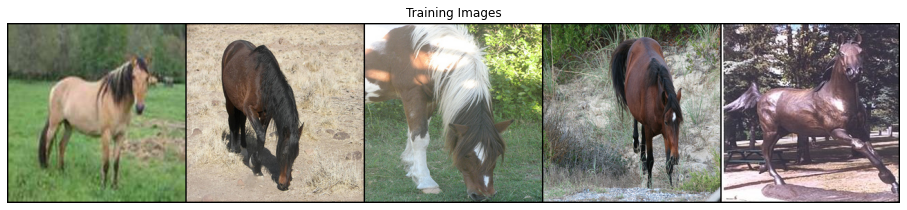

In [ ]:
workers = 2
image_size = (256,256)
batch_size = 5

dataroot = "/content/drive/MyDrive/horse2zebra_dataset/horse_train/"
dataset_horses_train = ImageFolder(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))

dataloader_train_horses = torch.utils.data.DataLoader(dataset_horses_train, 
                                                      batch_size=batch_size,shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_train_horses))
print(real_batch[0].shape)
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training(horse) Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

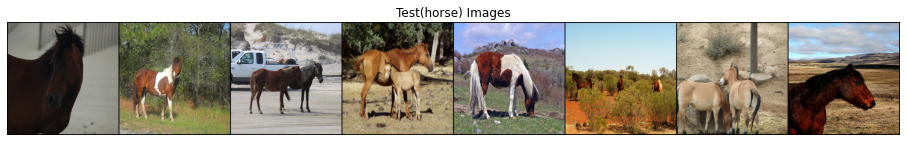

In [ ]:
dataroot = "/content/drive/MyDrive/horse2zebra_dataset/horse_test"
dataset_horses_test = ImageFolder(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horses = torch.utils.data.DataLoader(dataset_horses_test, batch_size=8,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_test_horses))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Test(horse) Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

Reading Train/Test zebra Image :

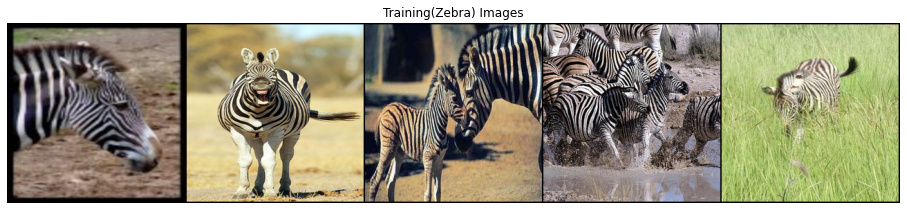

In [ ]:
dataroot = "/content/drive/MyDrive/horse2zebra_dataset/zebra_train"
dataset_zebra_train = ImageFolder(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_train))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training(Zebra) Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

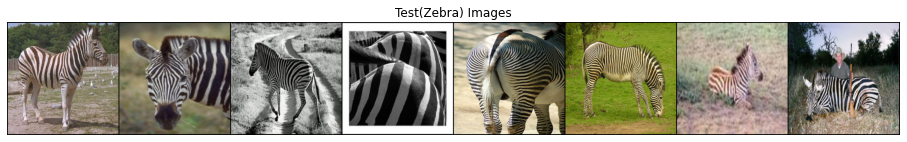

In [ ]:
dataroot = "/content/drive/MyDrive/horse2zebra_dataset/zebra_test"
dataset_zebra_test = ImageFolder(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=8,
                                         shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_zebra_test))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Test(Zebra) Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

CycleGan (Generator/ Discriminator ) :

In [ ]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [ ]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8,1,4,1,1)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [ ]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_Im = torch.nn.L1Loss() 

lr = 0.0002

beta1 = 0.5



In [ ]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  

  Loss_G = 0
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  for epoch in range(num_epochs):

    for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
        a_real = data_horse[0].to(device)
        b_real = data_zebra[0].to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)


        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # Fool discriminator
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses


        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == batch_size*5 and b_fake.shape[0]==batch_size):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del data_zebra, data_horse, a_real, b_real, a_fake, b_fake




    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))
    print("Epoch: " ,counter, " Generator loss: ",Loss_G, "  Discriminator loss (Horse):",list(df['Disc_loss_A'])[i],"  Discriminator loss (Zebra):", list(df['Disc_loss_B'])[i])



    iters = 0             

  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [ ]:
name="Basic9_old_256_training50"

epochs=11
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))



Training : 

In [ ]:
losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)


Epoch:  1  Generator loss:  4.701   Discriminator loss (Horse): 0.5289   Discriminator loss (Zebra): 0.3917
Epoch:  2  Generator loss:  4.281300000000001   Discriminator loss (Horse): 0.3888   Discriminator loss (Zebra): 0.4564
Epoch:  3  Generator loss:  3.7197   Discriminator loss (Horse): 0.6   Discriminator loss (Zebra): 0.5046
Epoch:  4  Generator loss:  4.359999999999999   Discriminator loss (Horse): 0.6934   Discriminator loss (Zebra): 0.4846
Epoch:  5  Generator loss:  3.2254   Discriminator loss (Horse): 0.4776   Discriminator loss (Zebra): 0.4343
Epoch:  6  Generator loss:  3.7309   Discriminator loss (Horse): 0.4376   Discriminator loss (Zebra): 0.3078
Epoch:  7  Generator loss:  4.229699999999999   Discriminator loss (Horse): 0.4765   Discriminator loss (Zebra): 0.4799
Epoch:  8  Generator loss:  3.1792999999999996   Discriminator loss (Horse): 0.4574   Discriminator loss (Zebra): 0.4584
Epoch:  9  Generator loss:  3.4766000000000004   Discriminator loss (Horse): 0.4219   D

Test result : 

In [ ]:
def zebra_to_horse(dataloader_test_horses, dataloader_zebra_test): 
    batch_a_test = next(iter(dataloader_test_horses))[0].to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test ).cpu().detach()


    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(vutils.make_grid((real_a_test[:10]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("horses")
    plt.show()

          
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(vutils.make_grid((fake_b_test[:10]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("horse to zebras")
    plt.show()


    batch_b_test = next(iter(dataloader_zebra_test))[0].to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()
    
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(vutils.make_grid((real_b_test[:10]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("zebras")
    plt.show()


    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(vutils.make_grid((fake_a_test[:10]+1)/2, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.axis("off")
    plt.title("zebra to horses")
    plt.show()

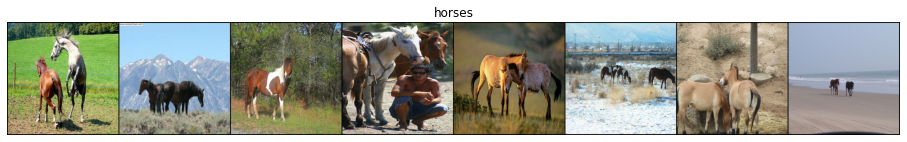

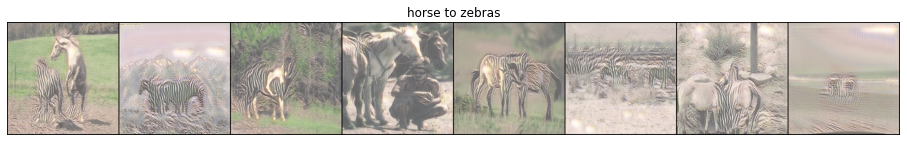

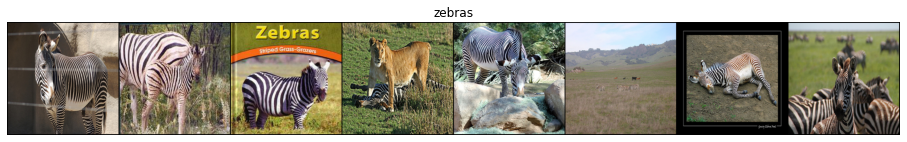

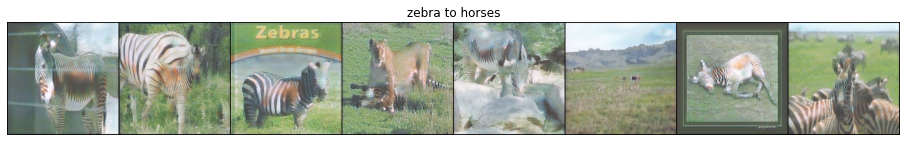

In [ ]:
zebra_to_horse(dataloader_test_horses, dataloader_zebra_test)

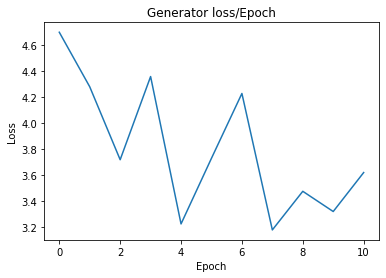

In [ ]:
import pandas as pd 
df = pd.read_csv("/content/cyclegan.csv",sep=" ")
df['generator']= df['Fool_disc_loss_A2B']+ df['Fool_disc_loss_B2A']+ df['Cycle_loss_A']+ df['Cycle_loss_B']+ df['Id_loss_B2A']+ df['Id_loss_A2B']

df
generator_loss  = [] 
for i,j in enumerate(list(df['generator'])):
  if (i+1) % 4 == 0 :
    generator_loss.append(j) 

plt.plot(generator_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss/Epoch")
plt.show()


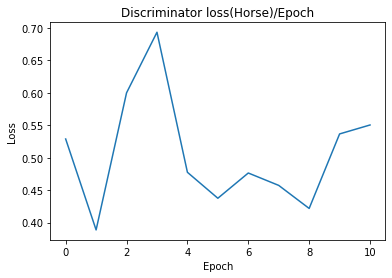

In [ ]:
Disc_loss_A  = [] 
for i,j in enumerate(list(df['Disc_loss_A'])):
  if (i+1) % 4 == 0 :
    Disc_loss_A.append(j) 

plt.plot(Disc_loss_A)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss(Horse)/Epoch")
plt.show()


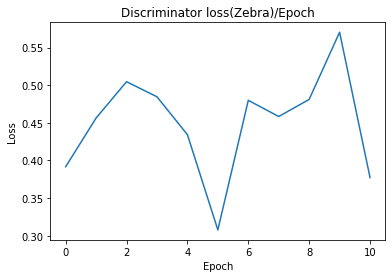

In [ ]:
Disc_loss_B  = [] 
for i,j in enumerate(list(df['Disc_loss_B'])):
  if (i+1) % 4 == 0 :
    Disc_loss_B.append(j) 

plt.plot(Disc_loss_B)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss(Zebra)/Epoch")
plt.show()
